# PHT Eclipsing Binary Catalog

- data covered: sectors 1 - 39 (2 years of Southern hemisphere and 1 year of Northern hemisphere)

In [1]:
from importlib import reload

from IPython.display import display, HTML, Markdown, clear_output

import numpy as np

import pandas as pd
from pandas.io.clipboard import clipboard_set

import matplotlib.pyplot as plt

import catalog
import catalog_stats
import dashboard_utils
from dashboard_utils import CAT_COLS_COMMON
from dashboard_utils import two_columns, n_columns
import vetting_meta

display(HTML("<style>.container { width:99% !important; }</style>"))

## At a Glance

In [2]:
# reload(catalog_stats)
# reload(dashboard_utils)
min_eb_score = 3  # empirically, the threshold that proxy accuracy >= 90% (see tagging accuracy)
styler_summary = dashboard_utils.display_summary(min_eb_score)
# print(styler_summary.data.to_markdown()) 

,
Num. of PHT Subjects,"28,092"
Num. of EBs / EB Candidates (TICs),"12,561"
Num. of EBs / EB Candidates with high certainty,"4,066"
Num. of sectors,39
First Sector,1
Last Sector,39
Num. of users,"1,320"


## Tagging accuracy and Catalog coverage

In [3]:
# reload(catalog_stats)
# reload(dashboard_utils)

df_catalog = dashboard_utils.get_catalog("pht_eb")

grid, col1, col2 = two_columns(also_return_outputs=True)

with col1:
    report, styler = catalog_stats.pivot_by_eb_score_group(df_catalog, also_return_styler=True)
    display(styler)

with col2:
    ax = report[report.index != "Totals"].plot.pie(y=('count', 'tic_id', 'Totals'));
    ax.set_title("TIC distribution by eb_score_group")
    plt.close(1)  # hide the plot outside the grid
    display(ax.get_figure())


display(grid);

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

### A rough estimate of the number of new eclipsing binaries
- i.e., not listed in the catalogs matched

In [4]:
# reload(catalog_stats)
res, report, styler = catalog_stats.estimate_num_ebs_not_in_catalog(df_catalog, min_eb_score=min_eb_score);
display(styler)
display(HTML(f"""Estimated number of EBs not in catalogs matched = 
<span style="background: rgba(255, 255, 0, 0.8)">{res.num_eb_not_in_catalog}</span>
&emsp;({res.num_not_classified} &times; {res.proxy_accuracy:.2%})
"""))

## Coverage of individual catalogs

In [5]:
report_simbad, styler_simbad = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="SIMBAD_Is_EB", also_return_styler=True)
# display(report_simbad[report_simbad.index == "Totals"])
display(two_columns(styler_simbad, styler))

report_vsx, styler_vsx = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="VSX_Is_EB", also_return_styler=True)
# display(report_vsx[report_vsx.index == "Totals"])
display(two_columns(styler_vsx, styler))

report_asas_sn, styler_asas_sn = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="ASASSN_Is_EB", also_return_styler=True)
# display(report_vsx[report_asas_sn.index == "Totals"])
display(two_columns(styler_asas_sn, styler))

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

### Compare raw number of EB votes vs adjusted eb_score 
- can we just use raw `num_votes_eb`, rather than adjusted `eb_score`, to gauge the likelihood of TIC being an eclipsing binary?

In [6]:
report_by_vote, styler_by_vote = catalog_stats.pivot_by_eb_score_group(df_catalog, index="num_votes_eb_group", also_return_styler=True)
styler_by_vote = styler_by_vote.set_caption("By raw num. of EB votes")
report, styler = catalog_stats.pivot_by_eb_score_group(df_catalog, index="eb_score_group", recalc_group=True, also_return_styler=True)
styler = styler.set_caption("By eb_score")
display(two_columns(styler_by_vote, styler))

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

## Sample TICs

In [7]:
reload(dashboard_utils)

df = df_catalog
df = (
    df
    [df["is_eb_catalog"] == "F"]
    .groupby("eb_score_group")
    .head(2)
    .sort_values(["eb_score_group"], ascending=[False])
    )
# clipboard_set(df[CAT_COLS_COMMON].to_markdown())
# df[CAT_COLS_COMMON].to_clipboard()

# dashboard_utils.style(df[CAT_COLS_COMMON])
dashboard_utils.style(df[["best_subject_img_id", ] + CAT_COLS_COMMON], show_thumbnail=True)

best_subject_img_id,tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_VAR_OTYPES,SIMBAD_Is_EB,VSX_OID,VSX_Type,VSX_Is_EB,VSX_Period,ASASSN_Name,ASASSN_URL,ASASSN_Type,ASASSN_Per,TESSEB_URL
,143669444,32026607,F,11,HD 64881,nan,-,409787,ACV|ELL,F,1.103900,J075359.20-453838.0,details,VAR,274.249967,details
,198537349,44563986,F,7,HD 141988,nan,-,58848,nan,-,nan,J154830.03+622040.8,details,ROT:,0.000000,details
,4200337,56365918,F,6,nan,nan,-,371037,BY,F,8.164117,J052244.88-010231.9,details,ROT,8.152767,details
,77209028,30249806,F,6,CD-38 1652,Ro*|V*,F,280953,ROT,F,0.568900,J043558.78-384134.0,details,VAR,0.000000,details
,17342647,48229829,F,5,HD 144359,nan,-,1546101,HB,F,4.382000,nan,nan,nan,nan,details
,29854488,52580003,F,5,nan,nan,-,,nan,-,nan,J013616.50-105235.0,details,ROT,2.300860,details
,22120766,41413067,F,4,CD-23 8836,V*|Ro*,F,90404,ROT,F,1.668000,J095357.05-240846.9,details,ROT:,0.000000,details
,22221233,41410027,F,4,TYC 6604-717-1,nan,-,,nan,-,nan,J095556.28-240307.8,details,ROT:,0.000000,details
,52357,64613852,F,3,HD 129195,V*,-,58594,VAR,-,0.377800,J144157.16-280357.6,details,L,0.000000,details
,8669966,48223652,F,3,* 32 Her,SB*,-,59130,ELL+DSCT,F,3.394306,J163329.10+302956.2,details,ROT:,0.000000,details


In [8]:
dashboard_utils.display_details(
    tic_id=10111251, 
    type="tic_meta",
    brief=True,
)
plt.close(1);  # hide the plot outside the grid

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

### TICs that are potentially mistagged

- `is_eb_catalog == "F"`, i.e., those that are listed in some catalogs, but classified as something else. 
    - current definition primarily various pulsators and rotators
    

#### Vetting of a sample of potentially mistagged TICs

- i.e., `is_eb_catalog == "F"`
- Results from top 20 TICs (by `eb_score`), 70 - 80% of those are eclipsing binaries. 
    - Most of them are eclipsing binaries with additional rotational or pulsating variability.
- The false positive (4 out of 20) are possibly exaggerated, as 3 out of 4 are due to contamination by a nearby eclipsing binary. 

In [9]:
df_vetting_statuses = vetting_meta.load_vetting_statuses_table(add_disposition_group=True)

df = df_vetting_statuses
df = df[df["In EB Catalogs"] == "F"]

pivot = df.pivot_table(
    columns=["Disposition_Group"],
    values=["TIC"],
    aggfunc=["count"],
    fill_value=0,  # convert NaN count result to zero
)
display(pivot.style.set_caption("""TICs with is_eb_catalog == "F" """))

display(df[["TIC", "Disposition", "Type", "Note"]].style.set_caption("""The List """))

,TIC,Disposition,Type,Note
0,143669444,Unsure,EB:|ELL:,"WIP: Possibly EB or ELL in VSX as ELL/ACV . Gaia DR3 Variable classifies as SPB. SO: It looks like EB or ELL, I would need a phase plot and an idea of the amplitude in mangitudes."
1,198537349,Candidate,EA,"in ASAS-SN as ROT:, in Gaia DR3 Variable as ACV-like. so maybe it is ROT+EA? SO: this is just EA, ASAS-SN often use ROT for unclassifiable targets, Gaia DR3 Variable maybe spurious"
2,281581467,Candidate,EA/RS,"in VSX/ASAS-SN as ROT:, in Gaia DR3 Variable as RS"
3,4200337,FP,,"contamination by a nearby eclipsingbinary (TIC 4200340, which has 1 sector of 30 min cadence data)"
4,77209028,Candidate,EA+ROT,
5,81329338,Candidate,EA/RS,"in ASAS-SN as ROT:, in Gaia DR3 Variable as RS"
6,140986621,Candidate,EA/RS,"possibly E/RS (ellipsodal effect), in ASAS-SN as ROT:, in Gaia DR3 Variable as ECL"
7,224308601,Candidate,EA+ROT,in ASAS-SN as ROT:
8,233006806,Candidate,EA+ROT,in ASAS-SN as ROT
9,259070502,Unsure,E:,"E possibly, unsure if the dips are due to contamination. TCE centroid offsets suggests so, but per-pixel plot indicate otherwise. TESS photometry is not reliable due to saturation ."


Breakdown of variable types for those with `is_eb_catalog == "F"`

In [10]:
df = df_catalog
df = df[(df["is_eb_catalog"] == "F") & (df["eb_score"] >= 3)]  # -np.inf  # to show all 

def pivot_of_type(df, type_column_name):
    if type_column_name == "SIMBAD_VAR_OTYPES":
        df = df[~pd.isna(df["SIMBAD_VAR_OTYPES"])]
    return (
        df
        .pivot_table(
            index=type_column_name,
            columns="eb_score_group", values="tic_id", aggfunc="count", margins=True,
            fill_value=0,  # convert NaN count result to zero
            )
        .sort_values(["All"], ascending=[False])
        )

num_rows = 11 # including the total, so top 10 types
styler_summary_vsx = pivot_of_type(df, "VSX_Type").head(num_rows).style
styler_summary_asassn = pivot_of_type(df, "ASASSN_Type").head(num_rows).style
styler_summary_simbad = pivot_of_type(df, "SIMBAD_VAR_OTYPES").head(num_rows).style

# with pd.option_context("display.max_rows", None, "display.max_columns", None):
display(Markdown("""##### TICs with `is_eb_catalog == "F"` """))
display(n_columns([styler_summary_vsx, styler_summary_asassn, styler_summary_simbad,]))

##### TICs with `is_eb_catalog == "F"` 

GridBox(children=(Output(layout=Layout(border_bottom='1px dotted gray', border_left='1px dotted gray', border_…

### TICs not classified in catalogs

- i.e., `is_eb_catalog == "-"` , those with no relevant classification in SIMBAD, VSX, and ASAS-SN

#### Vetting of a sample of TICs not classified in other catalogs

- Results from top 20 TICs (by `eb_score`), 80 - 95% of those are eclipsing binaries.
- The single sure false positive is due to contamination by a nearby eclipsing binary.

In [11]:
df_vetting_statuses = vetting_meta.load_vetting_statuses_table(add_disposition_group=True)

df = df_vetting_statuses
df = df[df["In EB Catalogs"] == "-"]

pivot = df.pivot_table(
    columns=["Disposition_Group"],
    values=["TIC"],
    aggfunc=["count"],
    fill_value=0,  # convert NaN count result to zero
)
display(pivot.style.set_caption("""TICs with is_eb_catalog == "-" """))

display(df[["TIC", "Disposition", "Type", "Note"]].style.set_caption("""The List """))

,TIC,Disposition,Type,Note
20,382517745,Candidate,EA,
21,340633943,Unsure,EB:|ELL:,"WIP: It might be EB, or ELL. If it's an EB, unclear on how to measure eclipse depth due to its variability SO: it's EB (ELL is symmetric with small amplitude), amplitude is peak to peak"
22,117739806,Candidate,EA,
23,29658499,Candidate?,EA,"Looks like EA, but only a single eclipse (~6% depth) is observed across ~80+ days of observation. Could still be a real EA with long-ish period."
24,139570309,Candidate:,EA,"WIP: vet it with archival data EA + possibly additional stars. 1 - 2 additional dips in sector 7 observation, WIP"
25,190693377,FP,,"NEB The contaminant is TIC 190693363 (Tmag 15.364, ~26 arcsec away), a known EW type listed in [VSX]"
26,272357134,Candidate,EA,
27,341549737,Candidate,EA,In Gaia DR3 Variable as ECL
28,32062341,Candidate?,EA,"Some chance the varibility originates from nearby TIC 32062334 (Tmag 10.482, ~4arcsec away). Target's RUWE (1.48) is more consistent with binary system."
29,93057033,Candidate:,EA+ROT,Maybe EA/RS In Gaia DR3 Variable as ECL


## EB Candidates Map

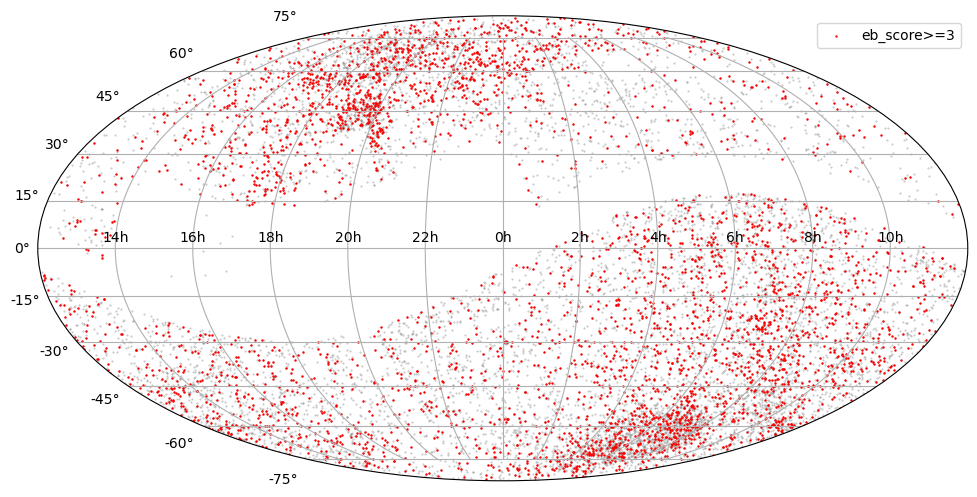

<Figure size 1200x900 with 0 Axes>

In [12]:
ax = dashboard_utils.plot_skymap(df_catalog, projection="mollweide");  # projection="lambert"
# highlight the better quality ones
ax = dashboard_utils.plot_skymap(df_catalog[df_catalog["eb_score"] >= 3], ax=ax, scatter_kwargs=dict(c="red", s=0.5, label="eb_score>=3"));
ax.legend();